In [1]:
import os
import time
import copy
import seaborn as sns
from collections import defaultdict
import torch
import torchvision
from torch.autograd import Variable
import shutil
import pandas as pd
from skimage import io
from skimage import transform
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
import cv2
import albumentations as albu
from albumentations.pytorch import ToTensor
from torch.optim import Adam, SGD
import torch.nn.functional as F
import zipfile
import random
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import warnings
from typing import Union, Sequence, Tuple
import torchvision as tv
import HRNet_OCR
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
cuda_gpu = torch.cuda.is_available()
if cuda_gpu:
    device = torch.device("cuda:0")
    torch.backends.cudnn.benchmark=True
else:
    device = torch.device("cpu:0")
print(device)

cpu:0


In [3]:
input_dir = "../steel/"
input_dir_Train  = os.path.join(input_dir, 'train_images')
input_dir_Test  = os.path.join(input_dir, 'test_images')
filelist_Train = os.listdir(input_dir_Train)
filelist_Test = os.listdir(input_dir_Test)
print('train data size : {}'.format(len(filelist_Train)))
print('test data size : {}'.format(len(filelist_Test)))

train data size : 12568
test data size : 5506


image shape : (256, 1600, 3)


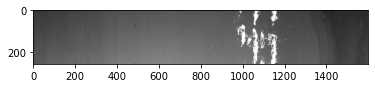

In [4]:
path = os.path.join(input_dir_Train, filelist_Train[12555])
image = cv2.imread(path)
plt.imshow(image)
print('image shape : {}'.format(image.shape))

In [5]:
df_path = os.path.join(input_dir, 'train.csv')
df = pd.read_csv(df_path)
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [6]:
print('defect num : {}'.format(df['ImageId'].nunique()))
print('no defect num : {}'.format(len(filelist_Train) - df['ImageId'].nunique()))

defect num : 6666
no defect num : 5902


In [7]:
defect_class = np.zeros((4))
for i in tqdm(range(len(df))):
    class_id = df.iloc[i]['ClassId']
    defect_class[class_id - 1] += 1

Text(0.5, 0, 'class')

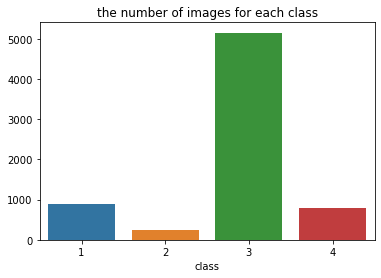

In [8]:
fig, ax = plt.subplots()
sns.barplot(x=np.arange(1, 5), y=defect_class, ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")

In [9]:
seed = 1234
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [10]:
def make_df(df):
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=seed)
    return train_df, val_df

In [11]:
train_df, val_df = make_df(df)

In [12]:
def make_mask(index, df):
    filename = df.iloc[index].name
    labels = df.iloc[index, :4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32)
    for idx, label in enumerate(labels):
        if label is not np.nan:
            mask = np.zeros((256*1600), dtype=np.uint8)
            pixels = label.split(' ')
            pixels = [pixels[i:i+2] for i in range(0, len(pixels), 2)]
            for pixel in pixels:
                pos, le = pixel
                pos, le = int(pos), int(le)
                mask[pos-1:pos+le-1] = 1
            masks[:,:,idx] = mask.reshape(256, 1600, order = 'F')
    return filename, masks

file name : 15e512a0f.jpg


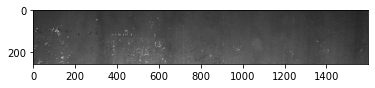

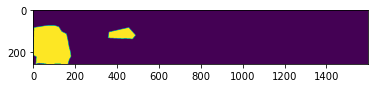

In [13]:
f, m = make_mask(139, train_df)
print('file name : {}'.format(f))
plt.imshow(cv2.imread(os.path.join(input_dir_Train, f)))
plt.show()
plt.imshow(m[:,:,2])
plt.show()

In [14]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
def get_augmentation(mean, std, phase):
    #这里用的albumentations库，据说比torch功能更多
    if phase == 'train':
        transform = [
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
            albu.Resize(256, 256, interpolation=cv2.INTER_NEAREST, p=1),
            albu.Normalize(mean=mean, std=std, p=1),
            albu.pytorch.ToTensor(),
        ]
    else:
        transform = [
            albu.Resize(256, 256, interpolation=cv2.INTER_NEAREST, p=1),
            albu.Normalize(mean=mean, std=std, p=1),
            albu.pytorch.ToTensor(),
        ]
    
    return albu.Compose(transform)

In [15]:
class steel_dataset(torch.utils.data.Dataset):
    def __init__(self, df, input_dir, phase):
        self.df = df
        self.input_dir = input_dir
        self.transforms = get_augmentation(mean, std, phase) 
        self.phase = phase
    def __getitem__(self, idx):
        filename, mask = make_mask(idx, self.df)
        image = cv2.imread(os.path.join(self.input_dir, filename))
        augmented = self.transforms(image=image, mask=mask)
        image, mask = augmented['image'], augmented['mask']
        mask = mask[0].permute(2, 0, 1)
        return image, mask
    def __len__(self):
        return len(self.df)

torch.Size([3, 256, 256])


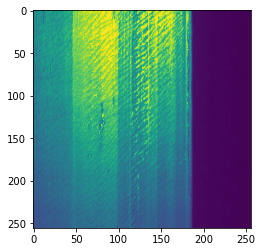

torch.Size([4, 256, 256])


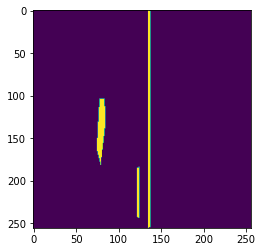

In [16]:
train_dataset = steel_dataset(train_df, input_dir_Train, phase = 'train')
val_dataset = steel_dataset(val_df, input_dir_Train, phase = 'val')

index = 0
image, mask = train_dataset.__getitem__(index) 
print(image.size())
plt.imshow(image.to('cpu').detach().numpy().copy()[0])
plt.show()
print(mask.size())
plt.imshow(mask.to('cpu').detach().numpy().copy()[2])
plt.show()

In [17]:
batch_size = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["train"])
inputs, labels = next(batch_iterator)
print('inputs size : {}'.format(inputs.size()))
print('labels size : {}'.format(labels.size()))

inputs size : torch.Size([4, 3, 256, 256])
labels size : torch.Size([4, 4, 256, 256])


In [ ]:
model = HRNet_OCR.get_HRNet_model(4)